So,

For simple crafting, an item $x$ has requirements $Y$, and to make $n$ of $x$, you need $nY$. If you want $nx/tick$, then you need $nY/tick$.

Now, if automatic crafting takes $t$ ticks to produce one item, and $c$ RF working at $r$ RF/tick, then with $q$ machines, 

$t=n\frac{c}{r}\quad$    $R=q/t$



Machine takes inputs, requires rf, uses it at a rate, then produces some outputs

The rate of output of those products is `probability of product * min(rate of requirements in, rate of machine/rf requirement)`


We want to say how much of some item we want, then calculate how much stuff we need.
e.g.

we want 1 iron per second or 0.05/tick:

```
quantities:
0.8 iron    <- 1 Redstone furnace <- 1 raw iron <- EMC I/O
                                   └ 1200 RF    <- Sterling Dynamo

time to produce 1:                                            
60/0.8 = 75 <- 1200/20 = 60 ticks <- 20 ticks   <- 20 ticks
                                   └ 1/20 ticks <- 1/40 ticks

75 ticks to produce 1 iron on average
```

Every machine needs to store what it produces, what it requires, and the rate at which it uses them as well as it's max rate

In [20]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
import json
inf = float("inf")

In [38]:
def ips(rate):
    return rate*20

def spi(rate):
    return 1/ips(rate)

In [39]:
with open("emc.json", "r") as f:
    EMC_long_keys = json.loads(f.read())

EMC = {}

for key in EMC_long_keys.keys():
    simple_key = key.split(":")[-1]
    EMC[simple_key] = EMC_long_keys[key]

EMC

{'cobblestone': 1,
 'grass_block': 16,
 'coal_ore': 128,
 'redstone_ore': 64,
 'glowstone_dust': 384,
 'emerald_ore': 16384,
 'lapis_ore': 864,
 'diamond_ore': 8192,
 'raw_iron': 256,
 'raw_gold': 2048,
 'raw_copper': 128,
 'raw_bauxite': 384,
 'raw_silver': 512,
 'raw_lead': 512,
 'raw_nickel': 1024,
 'raw_uranium': 4096,
 'raw_aluminum': 256,
 'raw_osmium': 2048,
 'raw_tin': 256,
 'raw_zinc': 3072,
 'fluorite_ore': 1024,
 'apatite_ore': 846,
 'oak_sapling': 32,
 'oak_log': 32,
 'clay_ball': 16,
 'seed': 16,
 'netherrack': 1,
 'soul_sand': 12,
 'cube1_packaged': 8192,
 'cube2_packaged': 20480,
 'cube3_packaged': 153600,
 'cube4_packaged': 460800,
 'oil_clump': 512,
 'cactus': 32,
 'sugar_cane': 32,
 'bone': 144,
 'red_matter': 58368,
 'magenta_matter': 181248,
 'dark_matter': 17408,
 'pink_matter': 568320,
 'lime_matter': 745294848,
 'purple_matter': 1803264,
 'yellow_matter': 2638537728,
 'blue_matter': 18981888,
 'green_matter': 214877184,
 'orange_matter': 9526225920,
 'cyan_matter

In [47]:
Item = str

def create_group(items:list[Item], quantities):
    group = pd.DataFrame({"quantity":quantities}, index=items)
    group.index.name = "item"
    return group


#class Group():
#    def __init__(self, items : list[Item], quantities):
#        self.items =pd.DataFrame({"quantity":quantities}, index=items)
#        self.items.index.name = "item"


class Recipe():
    def __init__(self, requirements:pd.DataFrame, result:pd.DataFrame):
        self.requirements = requirements
        self.result = result
        self.recipe = self.requirements.join(self.result, how="outer", rsuffix="_on").fillna(0)
        self.recipe.columns = ["in", "out"]
        #display(flow)
    
    def calc_rate(self, input_rate:pd.DataFrame):
        matched = input_rate.reindex(index=self.requirements.index, fill_value=0)
        rate = min(list(matched["quantity"] / self.requirements["quantity"])+[inf])
        return rate

        

class Machine:
    def __init__(self, input_machines=None, output_machines=None):
        self.input_machines = []
        self.output_machines = []
        self.rate = 0
        if input_machines:
            self.add_input_machines(input_machines)
        if output_machines:
            self.add_output_machines(output_machines)
    
    def add_input_machines(self, machines):
        self.input_machines += machines
        for m in machines:
            if self in m.output_machines:
                continue
            m.output_machines.append(self)
    
    def add_output_machines(self, machines):
        self.output_machines += machines
        for m in machines:
            if self in m.input_machines:
                continue
            m.input_machines.append(self)
    
    @property
    def input_rate(self):
        rate = create_group([],[])
        for input in self.input_machines:
            rate = rate.add(input.output_rate, fill_value=0)
        return rate
    
    @property
    def surplus_input(self):
        """ all input taken in but not consumed """
        input_rate = self.input_rate
        return input_rate - self.consumption_rate.reindex(index=input_rate.index, fill_value=0)
    
    @property
    def surplus_output(self):
        """ all output not taken in by another machine """
        rate = self.output_rate
        for output in self.output_machines:
            rate = rate - output.get_input_rate_from(self).reindex(index=rate.index, fill_value=0)
        
        return rate
    
    @property
    def flow(self):
        """ df: output <- consumption <- input """
        flow = self.output_rate
        flow = flow.join(self.consumption_rate, how="outer", rsuffix="1").fillna(0)
        flow = flow.join(self.input_rate, how="outer", rsuffix="2").fillna(0)
        flow.set_axis(["out", "consume", "in"], axis=1, inplace=True)
        return flow
    
    def get_input_rate_from(self, machine):
        """ the contribution of `machine` to this machine's input """
        return machine.output_rate if machine in self.input_machines else create_group([],[])


class Connection(Machine):
    max_rate = inf
    name = "Connection"
    def __init__(self, input_machine:Machine=None, output_machine:Machine=None, items:list[Item]=None, ratios:list[float]=None):
        self.items = items if items else []
        self.ratios = np.array(ratios).reshape(-1,1) if ratios else 1
        get_list = lambda x: [x] if x else []
        self.rate = 1
        super().__init__(input_machines=get_list(input_machine), 
                         output_machines=get_list(output_machine))

    @property
    def output_machine(self):
        return self.output_machines[0]
        
    @property
    def input_machine(self):
        return self.input_machines[0]

    @property
    def input_rate(self):
        input_rate = super().input_rate
        if (self.items != []):
            input_rate = input_rate.loc[self.items]
        return input_rate * self.ratios
    
    @property
    def output_rate(self):
        return self.input_rate

    @property
    def consumption_rate(self):
        return self.input_rate

    def get_input_rate_from(self, machine):
        if machine in self.input_machines:
            rate = machine.output_rate
            if (self.items != []):
                rate = rate.loc[self.items]
            return rate * self.ratios

    def update_rate(self):
        return self.rate



def create_machine(name, max_consumption=None, max_rate=inf):
    max_consumption = max_consumption if max_consumption is not None else create_group([],[])
    a,b,c= name, max_consumption, max_rate
    class New_Machine(Machine):
        name = a
        max_consumption = b
        max_rate = c

        def __init__(self, recipe, input_machines=None, output_machines=None):
            self.max_consumption = New_Machine.max_consumption.reindex(
                index=recipe.requirements.index.union(New_Machine.max_consumption.index),
                fill_value=inf
            )

            self.recipe = recipe
            super().__init__(input_machines, output_machines)
            
        @property
        def output_rate(self):
            return self.recipe.result * self.rate

        @property
        def input_rate(self):
            rate = create_group([],[])
            for input in self.input_machines:
                rate = rate.add(input.output_rate, fill_value=0)
            return rate

        @property
        def consumption_rate(self):
            return self.input_rate.clip(upper=self.max_consumption)
        
        def update_rate(self) -> float:
            self.rate = min(self.max_rate, self.recipe.calc_rate(self.input_rate))
            return self.rate

    New_Machine.__name__ = name
    return New_Machine


In [48]:
class Factory(Machine):
    def __init__(self):
        self.machines = []
    
    @property
    def output_nodes(self):
        return [m for m in self.machines if m.output_machines==[]]
    
    @property
    def input_nodes(self):
        return [m for m in self.machines if m.input_machines==[]]

    @property
    def edge_list(self):
        node_label_dict = {}
        edge_label_dict = {}
        G = nx.DiGraph()
        G.add_nodes_from(self.machines)
        for m in self.machines:
            node_label_dict[m] = m.name
            for n in m.input_machines:
                label = "\n".join(" ".join(s.split()) for s in n.output_rate.to_string().split("\n")[2:])
                edge_label_dict[(n,m)] = label
                G.add_edge(n,m)
        pos = nx.spring_layout(G)
        nx.draw(G, pos, node_color="gray", edge_color="black", width=2,labels=node_label_dict, with_labels=True)
        nx.draw_networkx_edge_labels(G, pos, edge_label_dict)
        plt.show()

    
    def add_machine(self, machine:Machine):
        self.machines.append(machine)
    
    def add_machines(self, machines:list[Machine]):
        for m in machines:
            self.add_machine(m)
    
    def sort_machines(self):
        sorted_machines = []
        def visit(m:Machine):
            if m in sorted_machines:
                return
            for n in m.input_machines:
                visit(n)
            sorted_machines.append(m)
        
        for n in self.output_nodes:
            visit(n)
        
        assert len(sorted_machines) == len(self.machines), "topological sorting didn't find all machines"
        self.machines = sorted_machines
    
    def update_rates(self):
        for m in self.machines:
            m.update_rate()
            

In [49]:
def consumption_limit(item:Item, rate):
    return create_group([item], [rate])

Basic_EMC_IO = create_machine("Basic_EMC_IO", pd.DataFrame(), 0.05)
GLOB_EMC = create_machine("GLOB_EMC")(Recipe(create_group([],[]), create_group(["emc"], [1])))
AUTO_CRAFTING_TABLE = create_machine("AUTO_CRAFTING_TABLE", consumption_limit("rf", 20))
RF_SOURCE = create_machine("RF_SOURCE", max_rate=40)(Recipe(create_group([],[]), create_group(["rf"], [1])))

def basic_emc_io(item:Item):
    return Basic_EMC_IO(Recipe(create_group(["emc"], [EMC[item]]), create_group([item], [1])), input_machines=[GLOB_EMC])

crafting_recipes = {
    "basic_mechanical_essence", Recipe(
        create_group(["iron_gear","aluminium_gear","copper_rod"], [1,1,2]), 
        create_group(["basic_mechanical_essence"], [1])),
    
}

press_recipes = {
    "iron_gear": Recipe(
        create_group(["iron_ingot", "rf"], [4, 2400]),
        create_group(["iron_gear"], [1])
    ),
    "aluminium_gear":Recipe(
        create_group(["aluminium_ingot", "rf"], [2, 2400]),
        create_group(["aluminium_gear"], [1])
    ),
    "copper_rod":Recipe(
        create_group(["copper_ingot", "rf"], [1, 600]),
        create_group(["copper_rod"], [2])
    ),
    "coal_block" : Recipe(
        create_group(["coal", "rf"], [9, 400]),
        create_group(["coal_block"], [1])
    )
}

redstone_furnace_recipes = {
    "iron_dust" : Recipe(
        create_group(["iron_dust", "rf"], [1, 2000]),
        create_group(["iron_ingot"], [1])
    ),
    "aluminium_dust":Recipe(
        create_group(["aluminium_dust", "rf"], [1, 2000]),
        create_group(["aluminium_ingot"], [1])
    ),
    "copper_dust":Recipe(
        create_group(["copper_dust", "rf"], [1, 2000]),
        create_group(["copper_ingot"], [1])
    ),
}

pulverisor_recipes = {
    "raw_iron" : Recipe(
        create_group(["raw_iron", "rf"], [1, 4000]),
        create_group(["iron_dust", "nickel_dust"], [1.2, 0.05])
    ),
    "raw_copper" : Recipe(
        create_group(["raw_copper", "rf"], [1, 4000]),
        create_group(["copper_dust", "gold_dust"], [1.2, 0.05])
    ),
    "raw_bauxite" : Recipe(
        create_group(["raw_bauxite", "rf"], [1, 4000]),
        create_group(["aluminium_dust", "iron_dust"], [1.2, 0.05])
    ),
    "coal_ore" : Recipe(
        create_group(["coal_ore", "rf"], [1, 4000]),
        create_group(["coal", "sulfur", "gravel"], [2.5, 0.15, 0.2])
    ),
}

stirling_fuel = {
    "coal" : 24000,
    "coal_block" : 240000
}

stirling_fuel_consumption_per_rf = {k:1/v for k,v in stirling_fuel.items()}
# generators are limited to a certain rf/tick, so we give recipe in terms of what is needed for 1 rf
# e.g. 1 peice of coal produces 24000 rf, therefore it takes 1/24000 peices of coal for 1 rf

STIRLING_GENERATOR = create_machine("STIRLING_GENERATOR", max_rate = 40)
def stirling_generator(fuel:Item):
    return STIRLING_GENERATOR(Recipe(
        create_group([fuel], [stirling_fuel_consumption_per_rf[fuel]]),
        create_group(["rf"], [1])
    ))

In [55]:
test_factory = Factory()

log_input = basic_emc_io("oak_log")
plank_crafting = AUTO_CRAFTING_TABLE(Recipe(create_group(["oak_log", "rf"],[1, 120]), create_group(["oak_planks"], [4])), 
                                     input_machines=[log_input, RF_SOURCE])
plank_pipe = Connection(plank_crafting, None)
door_crafting = AUTO_CRAFTING_TABLE(Recipe(create_group(["oak_planks", "rf"], [6, 120]), create_group(["oak_door"], [2])),
                                    input_machines=[plank_pipe, RF_SOURCE])

test_factory.add_machines([RF_SOURCE, log_input, GLOB_EMC, door_crafting, plank_crafting, plank_pipe])

order = [(n,test_factory.machines.index(m)) for m,n in zip([log_input, plank_crafting, door_crafting, plank_pipe, RF_SOURCE, GLOB_EMC], ["log","pipe", "plank", "door", "rf", "emc"])]
order.sort(key=lambda x:x[1])
print(order)

test_factory.sort_machines()
order = [(n,test_factory.machines.index(m)) for m,n in zip([log_input, plank_crafting, door_crafting, plank_pipe, RF_SOURCE, GLOB_EMC], ["log","pipe", "plank", "door", "rf", "emc"])]
order.sort(key=lambda x:x[1])
print(order)

test_factory.update_rates()
print([display(spi(m.output_rate)) for m in test_factory.output_nodes])

assert spi(door_crafting.output_rate.loc["oak_door"].item()) == (0.75), f"{door_crafting.output_rate.loc['oak_door']}"

[('rf', 0), ('log', 1), ('emc', 2), ('plank', 3), ('pipe', 4), ('door', 5)]
[('emc', 0), ('log', 1), ('rf', 2), ('pipe', 3), ('door', 4), ('plank', 5)]


,quantity
item,
oak_door,0.75


[None]


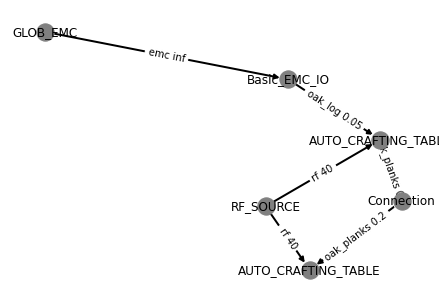

In [51]:
test_factory.edge_list
